In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import statsmodels.formula.api as smf
import datetime as dt

In [2]:
password="CCny23595140"
username="leslierosario40"
default_db="Fall_2022"
server= "localhost"
    
cnxn = pyodbc.connect(
         "DRIVER={ODBC Driver 17 For SQL Server};SERVER="
       + server
       + ";DATABASE="
       + default_db
       + ";UID="
       + username
       + ";PWD="
       + password
 )

In [3]:
cnxn

In [4]:
closed_restaurant_violations=pd.read_sql("SELECT rd.dba AS restaurant_name, vd.camis, rd.boro, rd.zipcode, rd.cuisine_description, vd.inspection_date, vd.violation_code, vd.violation_description, vd.score, vd.critical_flag, vd.[action], rd.longitude, rd.latitude FROM violation_data vd  JOIN restaurant_data rd  ON rd.camis=vd.camis  WHERE [action] LIKE 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.' AND boro != '0' AND zipcode IS NOT NULL GROUP BY vd.camis,rd.zipcode, vd.[action], vd.inspection_date, vd.score, vd.critical_flag, vd.violation_code, vd.violation_description, rd.dba,  rd.boro, rd.longitude, rd.latitude, rd.cuisine_description", con=cnxn)

In [5]:
closed_restaurant_violations.dtypes

restaurant_name                  object
camis                             int64
boro                             object
zipcode                          object
cuisine_description              object
inspection_date          datetime64[ns]
violation_code                   object
violation_description            object
score                           float64
critical_flag                    object
action                           object
longitude                       float64
latitude                        float64
dtype: object

In [6]:
closed_restaurant_violations.head(2)

,restaurant_name,camis,boro,zipcode,cuisine_description,inspection_date,violation_code,violation_description,score,critical_flag,action,longitude,latitude
0,SPOONBREAD TOO,40364179,Manhattan,10025,Soul Food,2018-05-23,02B,Hot food item not held at or above 140º F.,59.0,Critical,Establishment Closed by DOHMH. Violations were...,-73.960159,40.801373
1,SPOONBREAD TOO,40364179,Manhattan,10025,Soul Food,2018-05-23,02G,Cold food item held above 41º F (smoked fish a...,59.0,Critical,Establishment Closed by DOHMH. Violations were...,-73.960159,40.801373


In [7]:
closed_restaurant_violations.shape
#there are 8706 closed restaurant violations.

(8706, 13)

Obtained each closed restaurant by dropping duplicates of violations and only keeping the last duplicate of each camis.

In [8]:
closed_restaurants = closed_restaurant_violations.drop_duplicates(subset='camis', keep='last', inplace=False)
closed_restaurants.head(2)

,restaurant_name,camis,boro,zipcode,cuisine_description,inspection_date,violation_code,violation_description,score,critical_flag,action,longitude,latitude
4,SPOONBREAD TOO,40364179,Manhattan,10025,Soul Food,2018-05-23,05F,Insufficient or no refrigerated or hot holding...,59.0,Critical,Establishment Closed by DOHMH. Violations were...,-73.960159,40.801373
11,MARCHIS RESTAURANT,40364668,Manhattan,10016,Italian,2017-11-09,08A,Facility not vermin proof. Harborage or condit...,12.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.978333,40.743332


In [9]:
closed_restaurants.shape
#1,259 restaurants have closed at some point in NYC from 2015-2022

(1259, 13)

Violation Codes
Rates of violation codes from closure restaurant inspections.

In [10]:
close_violation_rate = closed_restaurant_violations.violation_code.value_counts()/len(closed_restaurant_violations)*100

In [11]:
close_violation_rate.head(5)

08A    14.553182
04L    10.303239
06C     6.995176
10F     6.581668
04M     5.938433
Name: violation_code, dtype: float64

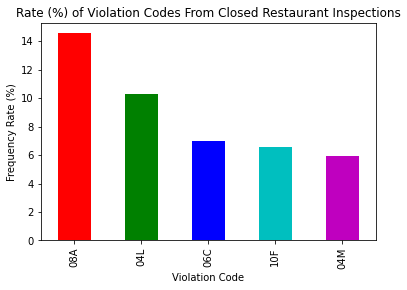

In [12]:
close_violation_rate.head(5).plot(kind="bar", color = ['r', 'g', 'b','c','m'])
plt.title('Rate (%) of Violation Codes From Closed Restaurant Inspections')
plt.ylabel('Frequency Rate (%)')
plt.xlabel('Violation Code')
plt.show()


In [13]:
all_restaurant_violations =pd.read_sql("SELECT violation_description, violation_code, camis FROM violation_data WHERE [action] != 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.' AND camis != '30075445'", con=cnxn)

In [14]:
first_inspection_closures = pd.read_sql("WITH all_camis_rank AS (SELECT restaurant_data.zipcode, violation_data.camis, restaurant_data.boro, restaurant_data.dba, violation_data.violation_description, violation_data.violation_code, violation_data.[action], violation_data.inspection_date, violation_data.grade, restaurant_data.cuisine_description, DENSE_RANK () OVER (PARTITION BY violation_data.camis ORDER BY violation_data.inspection_date ASC) CAMIS_RANK FROM violation_data LEFT JOIN restaurant_data  ON restaurant_data.camis=violation_data.camis WHERE violation_data.camis != 30075445 and inspection_date != '1900-01-01 00:00:00.0000000' GROUP BY restaurant_data.zipcode,violation_data.camis,restaurant_data.boro,restaurant_data.dba,violation_data.violation_description, violation_data.violation_code, violation_data.[action], violation_data.grade, restaurant_data.cuisine_description, violation_data.inspection_date) SELECT * FROM all_camis_rank WHERE CAMIS_RANK = 1 and action = 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'",con=cnxn)

In [15]:
first_inspection_closures.dtypes

zipcode                          object
camis                             int64
boro                             object
dba                              object
violation_description            object
violation_code                   object
action                           object
inspection_date          datetime64[ns]
grade                            object
cuisine_description              object
CAMIS_RANK                        int64
dtype: object

In [16]:
first_inspection_closure_rate =first_inspection_closures.violation_code.value_counts()

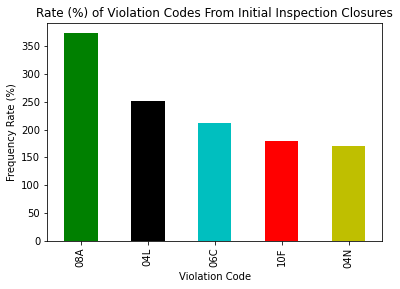

In [17]:
first_inspection_closure_rate.head(5).plot(kind="bar", color = ['g', 'k', 'c','r','y'])
plt.title('Rate (%) of Violation Codes From Initial Inspection Closures')
plt.ylabel('Frequency Rate (%)')
plt.xlabel('Violation Code')
plt.show()
#these are the violations that appeared in restaurants whose first inspection they had on record was failed and resulted in a closure.

Q. Which borough had the highest amount of closed restaurants? Which had the lowest?

In [18]:
closed_restaurants_boro = closed_restaurants.boro.value_counts()
closed_restaurants_boro.head()

Brooklyn         415
Manhattan        394
Queens           280
Bronx            142
Staten Island     28
Name: boro, dtype: int64

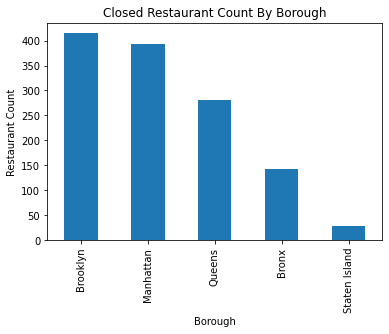

In [19]:
closed_restaurants_boro.plot(kind="bar")
plt.title('Closed Restaurant Count By Borough')
plt.ylabel('Restaurant Count')
plt.xlabel('Borough')
plt.show()
#this bar chart is skewed, lets see why below.

Uploaded a new csv file that contained all 27,483 restaurants with columns : boro, restaurant name, and zipcode to compare the percentages of closed restaurants.

In [20]:
all_restaurants=pd.read_sql("SELECT dba AS restaurant_name, boro, zipcode, cuisine_description FROM restaurant_data WHERE boro != '0' AND zipcode IS NOT NULL AND camis != 30075445",con=cnxn)

In [21]:
all_restaurants.head()
all_restaurants.shape

(27483, 4)

   Counted total number of restaurants in each borough.
   Notice Staten Island has the lowest restaurant population, 
which means it would always have the lowest amount of closed restaurants. 
   To accurately compare the boroughs, we need to compare the percent of closures by getting the rate of closures and multiplying it by 100.

In [22]:
all_restaurants.boro.value_counts()

Manhattan        10558
Brooklyn          7036
Queens            6349
Bronx             2520
Staten Island     1020
Name: boro, dtype: int64

In [23]:
percent_closed_by_boro = (closed_restaurants.boro.value_counts()/all_restaurants.boro.value_counts())*100

In [24]:
percent_closed_by_boro

Bronx            5.634921
Brooklyn         5.898238
Manhattan        3.731767
Queens           4.410143
Staten Island    2.745098
Name: boro, dtype: float64

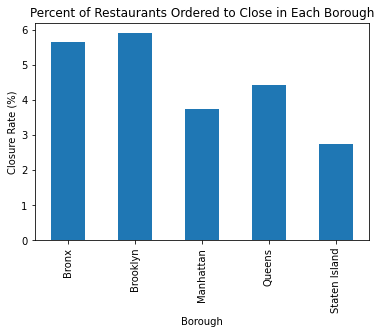

In [25]:
percent_closed_by_boro.plot(kind="bar")
plt.title('Percent of Restaurants Ordered to Close in Each Borough')
plt.ylabel('Closure Rate (%)')
plt.xlabel('Borough')
plt.show()
#Staten Island had the lowest closure rate while Brooklyn had double the rate

A: Brooklyn had the highest percent of restaurant that have closed at some point in the time constraints of the data (5.90%).
Staten Island had the lowest percent of closed restaurants (2.75%), 
Manhattan followed up at second lowest (3.73%). 

Zipcode closure rates by borough

In [26]:
ratio_zipcode_open_to_close = (closed_restaurants.zipcode.value_counts()/all_restaurants.zipcode.value_counts())*100
ratio_zipcode_open_to_close

10001    1.971326
10002    4.299065
10003    3.741007
10004    1.282051
10005    5.172414
           ...   
11692         NaN
11693    5.555556
11694    3.921569
11697         NaN
12345         NaN
Name: zipcode, Length: 221, dtype: float64

In [27]:
ratio_zipcode_open_to_close_df = ratio_zipcode_open_to_close.sort_values(ascending=False).rename_axis('zipcode').reset_index(name='Ratio')
ratio_zipcode_open_to_close_df['zipcode'] = ratio_zipcode_open_to_close_df['zipcode'].astype(str)
ratio_zipcode_open_to_close_df.head()

,zipcode,Ratio
0,11001,50.000000
1,11005,50.000000
2,10039,16.666667
3,11213,13.461538
4,11364,11.320755


In [28]:
all_restaurants['zipcode']  = all_restaurants['zipcode'].astype(str)
all_restaurants_boro_and_zips = all_restaurants[['boro', 'zipcode']]
all_restaurants_boro_and_zips.head()

,boro,zipcode
0,Brooklyn,11225
1,Manhattan,10019
2,Brooklyn,11224
3,Brooklyn,11234
4,Brooklyn,11226


In [29]:
ratio_zipcode_open_to_close_boro = pd.merge(ratio_zipcode_open_to_close_df,
                                            all_restaurants_boro_and_zips.drop_duplicates(),how = 'inner',on = 'zipcode')
ratio_zipcode_open_to_close_boro.head()

,zipcode,Ratio,boro
0,11001,50.000000,Queens
1,11005,50.000000,Queens
2,10039,16.666667,Manhattan
3,11213,13.461538,Brooklyn
4,11364,11.320755,Queens


In [30]:
closed_restaurants_Man = closed_restaurants[(closed_restaurants['boro'] == 'Manhattan')]
closed_restaurants_Man.head()                                                                           

,restaurant_name,camis,boro,zipcode,cuisine_description,inspection_date,violation_code,violation_description,score,critical_flag,action,longitude,latitude
4,SPOONBREAD TOO,40364179,Manhattan,10025,Soul Food,2018-05-23,05F,Insufficient or no refrigerated or hot holding...,59.0,Critical,Establishment Closed by DOHMH. Violations were...,-73.960159,40.801373
11,MARCHIS RESTAURANT,40364668,Manhattan,10016,Italian,2017-11-09,08A,Facility not vermin proof. Harborage or condit...,12.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.978333,40.743332
17,OLD HOMESTEAD,40364715,Manhattan,10011,American,2018-02-26,08A,Facility not vermin proof. Harborage or condit...,53.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-74.005035,40.741371
24,V & T RESTAURANT,40365577,Manhattan,10025,Italian,2019-07-05,10F,Non-food contact surface improperly constructe...,50.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.963615,40.803329
41,CHERRY TAVERN,40368271,Manhattan,10009,Bottled Beverages,2019-04-04,10F,Non-food contact surface improperly constructe...,46.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.985199,40.725994


In [31]:
all_restaurants_Man = all_restaurants[(all_restaurants['boro'] == 'Manhattan')]


In [32]:
ratio_cuisine_close_to_open_Man = (closed_restaurants_Man.cuisine_description.value_counts()/all_restaurants_Man.cuisine_description.value_counts())*100

In [33]:
ratio_cuisine_close_to_open_Man = ratio_cuisine_close_to_open_Man.dropna()
ratio_cuisine_close_to_open_Man.head()

Afghan                20.000000
African               10.000000
American               2.306353
Asian/Asian Fusion     6.250000
Australian            13.333333
Name: cuisine_description, dtype: float64

In [34]:
ratio_cuisine_close_to_open_Man_df = ratio_cuisine_close_to_open_Man.sort_values(ascending=False).rename_axis('cuisine_description')
ratio_cuisine_close_to_open_Man_df.head(10)

cuisine_description
Pakistani           33.333333
Bangladeshi         33.333333
Afghan              20.000000
Russian             20.000000
Filipino            20.000000
Ethiopian           20.000000
Southeast Asian     19.354839
Brazilian           18.181818
Chinese/Japanese    15.000000
Indian              14.960630
Name: cuisine_description, dtype: float64

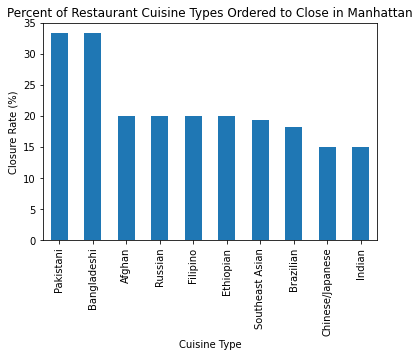

In [35]:
ratio_cuisine_close_to_open_Man_df.head(10).plot(kind="bar")
plt.title('Percent of Restaurant Cuisine Types Ordered to Close in Manhattan')
plt.ylabel('Closure Rate (%)')
plt.xlabel('Cuisine Type')
plt.show()

In [36]:
closed_restaurants_SI = closed_restaurants[(closed_restaurants['boro'] == 'Staten Island')]
closed_restaurants_SI.shape

(28, 13)

In [37]:
all_restaurants_SI = all_restaurants[(all_restaurants['boro'] == 'Staten Island')]
all_restaurants_SI.shape

(1020, 4)

In [38]:
ratio_cuisine_close_to_open_SI = (closed_restaurants_SI.cuisine_description.value_counts()/all_restaurants_SI.cuisine_description.value_counts())*100

In [39]:
ratio_cuisine_close_to_open_SI_df = ratio_cuisine_close_to_open_SI.dropna()
ratio_cuisine_close_to_open_SI_df.tail()

Peruvian      33.333333
Pizza          0.980392
Russian       50.000000
Sandwiches     3.333333
Thai          20.000000
Name: cuisine_description, dtype: float64

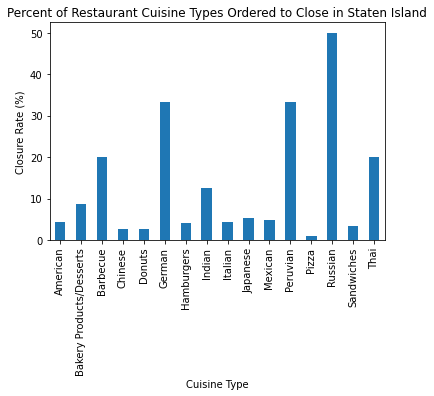

In [40]:
ratio_cuisine_close_to_open_SI_df.plot(kind="bar")
plt.title('Percent of Restaurant Cuisine Types Ordered to Close in Staten Island')
plt.ylabel('Closure Rate (%)')
plt.xlabel('Cuisine Type')
plt.show()

Q. What month were there the most closure violations? What month had the least?

In [41]:
closed_restaurants['Month'] = closed_restaurants['inspection_date'].dt.month

/tmp/ipykernel_2172434/1632789581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_restaurants['Month'] = closed_restaurants['inspection_date'].dt.month


,restaurant_name,camis,boro,zipcode,cuisine_description,inspection_date,violation_code,violation_description,score,critical_flag,action,longitude,latitude,Month
8696,NICE CHINATOWN,50123254,Brooklyn,11230,Chinese,2022-06-17,10F,Non-food contact surface improperly constructe...,59.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.963760,40.633732,6
8705,ALMAH COFFEE SHOP,50124859,Brooklyn,11213,Jewish/Kosher,2022-08-02,10F,Non-food contact surface or equipment made of ...,77.0,Not Critical,Establishment Closed by DOHMH. Violations were...,-73.930435,40.675930,8


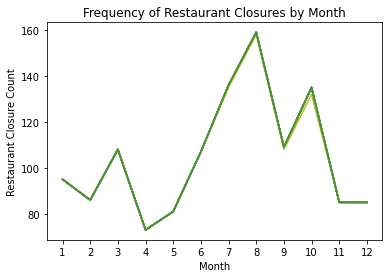

In [42]:
months = [month for month, df in closed_restaurants.groupby('Month')]

months_scatter = plt.plot(months, closed_restaurants.groupby(['Month']).count())
plt.xticks(months)
plt.title('Frequency of Restaurant Closures by Month')
plt.ylabel('Restaurant Closure Count')
plt.xlabel('Month')
plt.show()

Part 1 A: Inspections resulting in a closure occured the most during the summer months (July, August). Restaurant inspections resulting a closure occured least during mid spring (April, May), as well as those in the winter months (November-February).

We still need to see how a new restaurant will do. We extracted all restaurants that closed on the first recorded initial inspection.

In [43]:
first_unique_inspection_closures = first_inspection_closures.drop_duplicates(subset='camis', keep='last', inplace=False)
first_unique_inspection_closures.shape
#451 restaurants closed on their first recorded initial inspection

(451, 11)

In [44]:
first_unique_inspection_closures['Month'] = first_unique_inspection_closures['inspection_date'].dt.month

/tmp/ipykernel_2172434/3208423526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_unique_inspection_closures['Month'] = first_unique_inspection_closures['inspection_date'].dt.month


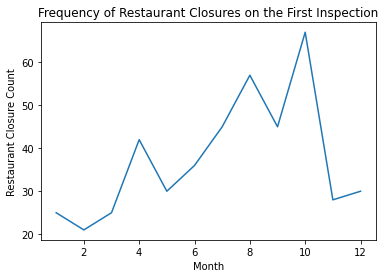

In [45]:
first_unique_inspection_closures['Month'].value_counts().sort_index().plot(kind='line')
plt.title('Frequency of Restaurant Closures on the First Inspection')
plt.ylabel('Restaurant Closure Count')
plt.xlabel('Month')
plt.show()